# Chapter 2: Gradient Descent -- Where Magic Happens

Machine learning can be summarized in three words: initialize, adjust, and repeat.

The idea behind machine learning is surprisingly simple. It basically follows three steps:
Step 1: Randomly assign values to the model parameters;
Step 2: Make predictions using the model based on the current parameters; compare the predictions with the actual values; then adjust parameters accordingly: if the prediction is too large (small), adjust the parameters so that the prediction will be smaller (larger);
Step 3: Repeat step 2 thousands or millions of times until the parameters converge. 

Such a simple idea leads to amazing results, including beating the World Champion in the Go game, recognizing images, self-driving cars… 

Step 2 or the word "adjust" is where the magic of machine learning happens. It's done through gradient descent or some variant of it. 

By the end of the chapter, you'll learn to create animations to show step by step how gradient descent changes the parameter values so that a certain goal is achieved. You'll also be able to create animations of the learning process with different values of the learning rate, like so:<br>
<img src="https://gattonweb.uky.edu/faculty/lium/ml/largetosmall.gif" />

Machine learning is the process of finding a way to make predictions that leads to the lowest forecasting error. In mathematical terms, machine learning is trying to find parameter values that minimize the loss function. But how? The answer lies in gradient descent (or some variations of it). In this chapter, you'll learn how gradient descent helps us find the right parameter values quickly and efficiently.

Specifically, you'll learn that machine learning algorithms make gradual changes to the parameter values. The change is proportional to the negative value of the first derivative of the loss function. Hence the name gradient descent: the word gradient refers to the first derivative, and word descent comes from the negative sign in the change (each step, the adjustment is equal to $ -1 \times Learning Rate \times gradient.$).

The $Learning\ Rate$ term in the above formula is a value that we use to control how quickly we adjust the parameter values. Adjusting too quickly (i.e., using too large a learning rate), the parameters may not converge. Adjusting too slowly, it takes too long for the parameters to converge, as demonstrated in the above animation.

***
$\mathbf{\text{Create a subfolder for files in Chapter 2}}$<br>
***
We'll put all files in Chapter 2 in a subfolder /files/ch02. The code in the cell below will create the subfolder.

***

In [1]:
import os

os.makedirs("files/ch02", exist_ok=True)

Before you start, install the ***tensorflow*** Python library on your computer. Run the following line of command in the Anaconda prompt (Windows) or a terminal (Mac or Linux), with your virtual environment ***animatedML*** activated:

`pip install tensorflow` 

Make sure you restart the Jupyter Notebook app on your computer after installation for the library to take effect. 

## 1. Optimization through Grid Search

### 1.1. How Grid Search Achieves Optimization
Suppose you want to find the value of $x$ to minimize the value of $y=(x-10)^2$. A brute force approach is to look at many different values of $x$ and see which one leads to the lowest value of $y$.<br>

This can easily be done in Python as follows:

In [2]:
import numpy as np

x=np.linspace(0,20,2000)
y=(x-10)**2

min_y = np.min(y)
argmin_y = np.argmin(y)
print(f"index value of the minimum y is {argmin_y}")
best_x = x[argmin_y]
print(f"the minimum y is {min_y} when x is {best_x}")

index value of the minimum y is 1000
the minimum y is 2.5025018762497603e-05 when x is 10.005002501250624


We use the *linspace()* method in ***numpy*** to create 2000 different values of x between 0 and 20. For each value of $x$, we calculate the value of $y=(x-10)^2$. The *min()* method returns the lowest value of $y$ and we call the value *min_y*. The *argmin()* method returns the index value of the lowest $y$. The output from the above cell tells us that the 1000th $y$ has the lowest value. We can also find out the optimal $x$ by using the index. The results show that when $x=10.005$, the minimum value of $y$ is achieved, at $y=0.000025$, which is very close to the true minimum value of 0.

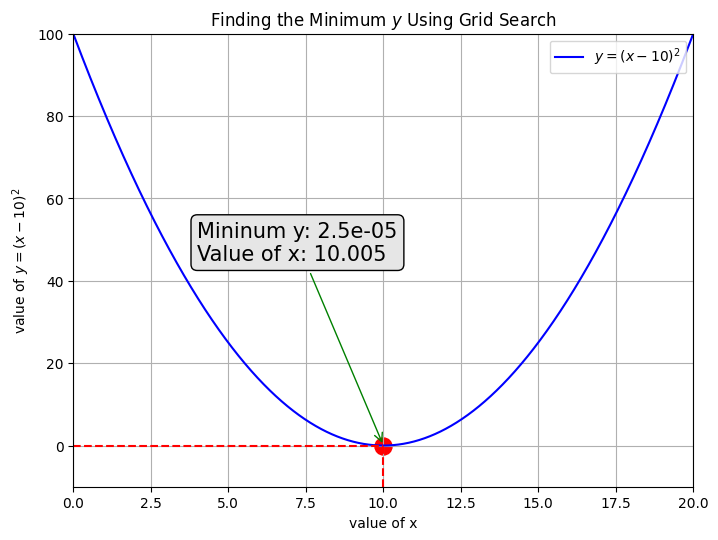

In [3]:
from matplotlib import pyplot as plt

fig, ax=plt.subplots(figsize=(8,6), dpi=100)
plt.grid()
ax.plot(x,y,color = 'blue',label="$y=(x-10)^2$")
plt.scatter(best_x, min_y, color = 'red', s=150)
ax.plot([0,10],[0,0],color='red',linestyle='dashed')
ax.plot([10,10],[-10,0],color='red',linestyle='dashed')
ax.set_xlim(0,20)
ax.set_ylim(-10,100)
ax.set_xlabel("value of x")
ax.set_ylabel("value of $y=(x-10)^2$")
ax.set_title("Finding the Minimum $y$ Using Grid Search")
plt.legend(loc="upper right")
# add text to explain 
txt = ax.annotate(
    f'Mininum y: {round(min_y, 6)}\nValue of x: {round(best_x, 3)}', 
    xy = (best_x, min_y), 
    xytext = (0.2,0.5), 
    textcoords = 'axes fraction', 
    bbox = dict(boxstyle="round", fc="0.9"), 
    arrowprops=dict(arrowstyle = '->', color = 'g', linewidth = 1), 
    fontsize = 15)

### 1.2. Curse of Dimensionality and Directional Grid Search
Grid search works only if the number of parameters is small. In the above example, we only need to find out one parameter, $x$. Many machine learning models, such as neural networks, has thousands or even millions of parameters. It's infeasible to conduct a grid search. 

To illustrate the point, suppose you want to find the values of 10 parameters, $x_1$, $x_2$,...$x_{10}$, to minimize the value of $y=(x_1-1)^2+(x_2-2)^2+...+(x_{10}-10)^2$. If we search 2000 values for each parameter as we did in the above example, the total number of possibilities is $2000^{10}$, an astronomical number. This is the so-called curse of dimensionality problem with grid search.

One solution to speed up grid search is to use the gradients to guide us as to which direction to go. 

***
$\mathbf{\text{Move in the opposite direction of the gradient}}$<br>
***
By definition, the first derivative of a function $f(x)$ with respect to $x$ is $$f'(x)=\lim_{h \to 0}\frac{f(x+h)-f(x)}{(x+h)-x}$$
It tells us when the value of $x$ changes by a small amount, how much will the value of $f(x)$ change.

In particular, $f'(x)>0$ means that when $x$ increases, the value of $f(x)$ decreases, and vice versa.

Therefore, in order to minimize the value of $y$, we should move in the opposite direction of the first derivative $\frac{dy}{dx}$. Why? If $\frac{dy}{dx}>0$, this tells us that when we increase $x$, the value of $y$ will also increase. But since we want to minimize the value of $y$, by reducing the value of $x$, we'll reduce the value of $y$ to achieve our goal.

***

Next, we'll implement the idea of the directional grid search. Suppose when the incremental change of $y$ is less than 0.0001, we consider the value to be converged and the minimum is found. If the value of $y$ doesn't converge after 2000 iterations, we consider the directional grid search a failure. 

A critical hyperparameter to choose is the incremental change in each iteration. If the incremental change is too small, it takes too long to converge and it's computationally costly.
* Case 1: When the incremental change is too small (we increase the value of $x$ by 0.001 in each iteration)

In [4]:
# randomly selects an initial value of x
x0=1.2345
y0=(x0-10)**2

# how much to adjust the value of x each iteration
step = 0.001

# keep track of the values of x and y
ys = []
xs = []
xs.append(x0)
ys.append(y0)

# find the derivative. Since y=(x-10)^2, dy/dx=2(x-10)
def dydx(x):
    dydx = 2*(x-10)
    return dydx

# starts the directional grid search
x=x0
for i in range(1,2001,1):
    # directional grid search
    if dydx(x)>0:
        x = x - step
    else:
        x = x + step
    # calculate current value of y
    y=(x-10)**2
    # record values of x and y
    xs.append(x)
    ys.append(y)
    # if the incremental change is small than 0.0001, stop
    if abs(ys[-1]-ys[-2])<=0.0001:
        print(f"find minimum after {i} steps")
        print(f"the minimum y is {ys[-1]} when x is {xs[-1]}")
        break
    # if y doesn't converge after 2000 iterations, quit
    else:
        if i==2000:
            print("fail to find the minimum")              

# keep track of min_y, argmin_y, and best_x in this case for plots later            
min_y = y
argmin_y = i
best_x = x

fail to find the minimum


The results show that after 2000 steps, the value of $y$ doesn't converge. The graph below shows the path of $(x,y)$ in each iteration.

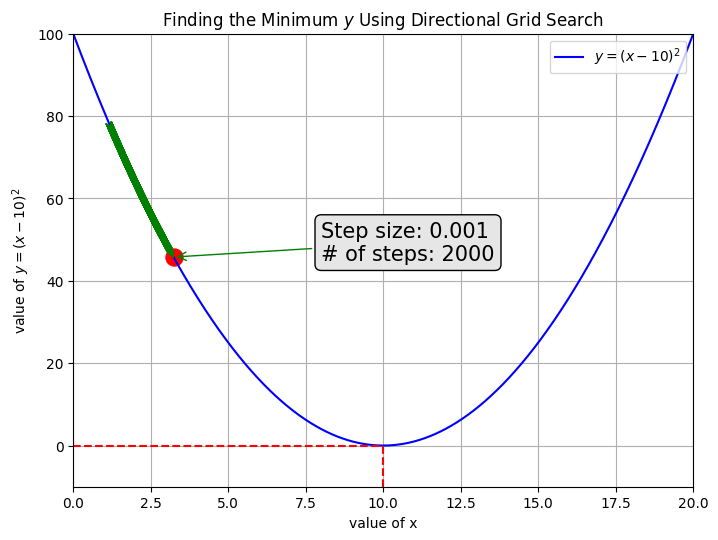

In [5]:
fig, ax=plt.subplots(figsize=(8,6), dpi=100)
plt.grid()
x=np.linspace(0,20,2000)
y=(x-10)**2
ax.plot(x,y,color = 'blue',label="$y=(x-10)^2$")
plt.scatter(best_x, min_y, color = 'red', s=150)
ax.plot([0,10],[0,0],color='red',linestyle='dashed')
ax.plot([10,10],[-10,0],color='red',linestyle='dashed')
ax.set_xlim(0,20)
ax.set_ylim(-10,100)
ax.set_xlabel("value of x")
ax.set_ylabel("value of $y=(x-10)^2$")
ax.set_title("Finding the Minimum $y$ Using Directional Grid Search")
plt.legend(loc="upper right")
# add text to explain 
txt = ax.annotate(
    f'''Step size: {step}\n# of steps: {argmin_y}''', 
    xy = (best_x, min_y), 
    xytext = (0.4,0.5), 
    textcoords = 'axes fraction', 
    bbox = dict(boxstyle="round", fc="0.9"), 
    arrowprops=dict(arrowstyle = '->', color = 'g', linewidth = 1), 
    fontsize = 15)
# Show the path of the directional grid search

for k in range(len(xs)-1):
    ax.annotate("", 
    xy = (xs[k+1], ys[k+1]), 
    xytext = (xs[k], ys[k]), 
    textcoords = 'data', 
    bbox = dict(boxstyle="round", fc="0.9"), 
    arrowprops=dict(arrowstyle = '->', color = 'g', linewidth = 1))

If the incremental change is too large, the value of $y$ will oscillate back and forth between points to the left and to the right of the true minimum, and never converge.
* Case 2: When the incremental change is too large (we increase the value of $x$ by 8 in each iteration)

In [6]:
# randomly selects an initial value of x
x0=1.2345
y0=(x0-10)**2

# how much to adjust the value of x each iteration
step = 8

# keep track of the values of x and y
ys = []
xs = []
xs.append(x0)
ys.append(y0)

# find the derivative. Since y=(x-10)^2, dy/dx=2(x-10)
def dydx(x):
    dydx = 2*(x-10)
    return dydx

# starts the directional grid search
x=x0
for i in range(1,2001,1):
    # directional grid search
    if dydx(x)>0:
        x = x - step
    else:
        x = x + step
    # calculate current value of y
    y=(x-10)**2
    # record values of x and y
    xs.append(x)
    ys.append(y)
    # if the incremental change is small than 0.0001, stop
    if abs(ys[-1]-ys[-2])<=0.0001:
        print(f"find minimum after {i} steps")
        print(f"the minimum y is {ys[-1]} when x is {xs[-1]}")
        break
    # if y doesn't converge after 2000 iterations, quit
    else:
        if i==2000:
            print("fail to find the minimum")              

# keep track of min_y, argmin_y, and best_x in this case for plots later            
min_y = y
argmin_y = i
best_x = x

fail to find the minimum


The results show that after 2000 steps, the value of $y$ doesn't converge. The graph below shows the path of $(x,y)$ in each iteration.

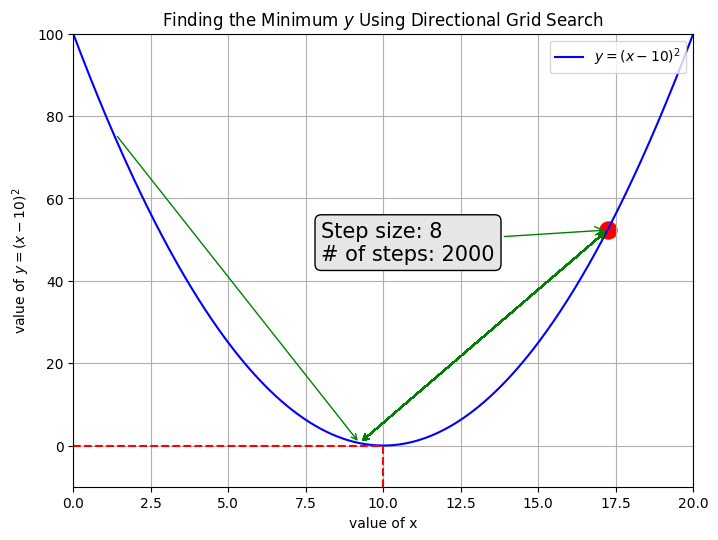

In [7]:
fig, ax=plt.subplots(figsize=(8,6), dpi=100)
plt.grid()
x=np.linspace(0,20,2000)
y=(x-10)**2
ax.plot(x,y,color = 'blue',label="$y=(x-10)^2$")
plt.scatter(best_x, min_y, color = 'red', s=150)
ax.plot([0,10],[0,0],color='red',linestyle='dashed')
ax.plot([10,10],[-10,0],color='red',linestyle='dashed')
ax.set_xlim(0,20)
ax.set_ylim(-10,100)
ax.set_xlabel("value of x")
ax.set_ylabel("value of $y=(x-10)^2$")
ax.set_title("Finding the Minimum $y$ Using Directional Grid Search")
plt.legend(loc="upper right")
# add text to explain 
txt = ax.annotate(
    f'''Step size: {step}\n# of steps: {argmin_y}''', 
    xy = (best_x, min_y), 
    xytext = (0.4,0.5), 
    textcoords = 'axes fraction', 
    bbox = dict(boxstyle="round", fc="0.9"), 
    arrowprops=dict(arrowstyle = '->', color = 'g', linewidth = 1), 
    fontsize = 15)
# Show the path of the directional grid search

for k in range(len(xs)-1):
    ax.annotate("", 
    xy = (xs[k+1], ys[k+1]), 
    xytext = (xs[k], ys[k]), 
    textcoords = 'data', 
    bbox = dict(boxstyle="round", fc="0.9"), 
    arrowprops=dict(arrowstyle = '->', color = 'g', linewidth = 1))

The above graph shows that the value of $x$ oscillates between 9.2345 and 17.2345. The value of $y$ never converges.

Now let's consider a moderate value of the incremental change. 
* Case 3: When the incremental change is moderate (we increase the value of $x$ by 0.01 in each iteration)

In [8]:
# randomly selects an initial value of x
x0=1.2345
y0=(x0-10)**2

# how much to adjust the value of x each iteration
step = 0.01

# keep track of the values of x and y
ys = []
xs = []
xs.append(x0)
ys.append(y0)

# find the derivative. Since y=(x-10)^2, dy/dx=2(x-10)
def dydx(x):
    dydx = 2*(x-10)
    return dydx

# starts the directional grid search
x=x0
for i in range(1,2001,1):
    # directional grid search
    if dydx(x)>0:
        x = x - step
    else:
        x = x + step
    # calculate current value of y
    y=(x-10)**2
    # record values of x and y
    xs.append(x)
    ys.append(y)
    # if the incremental change is small than 0.0001, stop
    if abs(ys[-1]-ys[-2])<=0.0001:
        print(f"find minimum after {i} steps")
        print(f"the minimum y is {ys[-1]} when x is {xs[-1]}")
        break
    # if y doesn't converge after 2000 iterations, quit
    else:
        if i==2000:
            print("fail to find the minimum")              

# keep track of min_y, argmin_y, and best_x in this case for plots later            
min_y = y
argmin_y = i
best_x = x

find minimum after 877 steps
the minimum y is 2.0249999998482748e-05 when x is 10.004499999999831


The results show that after 877 steps, the value of $y$ converges. The minimum value of $y$, 2.025e-5, is even smaller than the one we find using grid search, 2.5e-5.

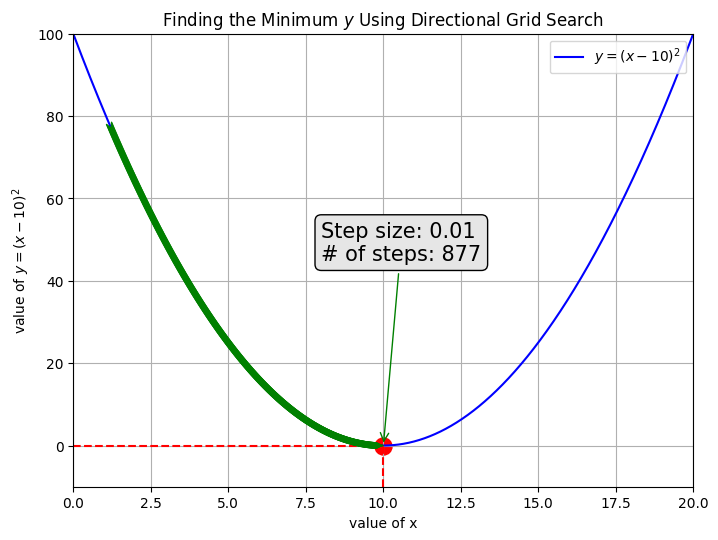

In [9]:
fig, ax=plt.subplots(figsize=(8,6), dpi=100)
plt.grid()
x=np.linspace(0,20,2000)
y=(x-10)**2
ax.plot(x,y,color = 'blue',label="$y=(x-10)^2$")
plt.scatter(best_x, min_y, color = 'red', s=150)
ax.plot([0,10],[0,0],color='red',linestyle='dashed')
ax.plot([10,10],[-10,0],color='red',linestyle='dashed')
ax.set_xlim(0,20)
ax.set_ylim(-10,100)
ax.set_xlabel("value of x")
ax.set_ylabel("value of $y=(x-10)^2$")
ax.set_title("Finding the Minimum $y$ Using Directional Grid Search")
plt.legend(loc="upper right")
# add text to explain 
txt = ax.annotate(
    f'''Step size: {step}\n# of steps: {argmin_y}''', 
    xy = (best_x, min_y), 
    xytext = (0.4,0.5), 
    textcoords = 'axes fraction', 
    bbox = dict(boxstyle="round", fc="0.9"), 
    arrowprops=dict(arrowstyle = '->', color = 'g', linewidth = 1), 
    fontsize = 15)
# Show the path of the directional grid search

for k in range(len(xs)-1):
    ax.annotate("", 
    xy = (xs[k+1], ys[k+1]), 
    xytext = (xs[k], ys[k]), 
    textcoords = 'data', 
    bbox = dict(boxstyle="round", fc="0.9"), 
    arrowprops=dict(arrowstyle = '->', color = 'g', linewidth = 1))

## 2. Gradient Descent
The directional grid search approach cut the searching iterations by more than half, from 2000 to 877. However, when the number of parameters is large, even directional grid search is prohibitively costly computationally. Therefore, we'll use the gradient descent algorithm to further reduce the computational needs. The idea is that in each iteration, we'll adjust the value of $x$ proportional to the magnitude of the gradient. 

When the magnitude of the gradient $\frac{dy}{dx}$ is large, the point $(x,y)$ is far away from the minimum point. Making a large adjustment will not overshoot. The large adjustment will speed up the optimization process. When the magnitude of the gradient $\frac{dy}{dx}$ is small, the point $(x,y)$ is close the minimum point. Making a large change may lead to overadjustment. The small adjustment will make sure that the value of $x$ doesn't overshoot to the other side of the minimum point. 

In [1]:
from matplotlib import pyplot as plt
import numpy as np

# randomly selects an initial value of x
x0=1.2345
y0=(x0-10)**2

# how much to adjust the value of x each iteration
learning_rate = 0.1

# keep track of the values of x and y
ys = []
xs = []
xs.append(x0)
ys.append(y0)

# find the derivative. Since y=(x-10)^2, dy/dx=2(x-10)
def dydx(x):
    dydx = 2*(x-10)
    return dydx

# starts the directional grid search
x=x0
for i in range(1,2001,1):
    # gradient descent
    x = x - learning_rate * dydx(x)
    # calculate current value of y
    y=(x-10)**2
    # record values of x and y
    xs.append(x)
    ys.append(y)
    # if the incremental change is small than 0.0001, stop
    if abs(ys[-1]-ys[-2])<=0.0001:
        print(f"find minimum after {i} steps")
        print(f"the minimum y is {ys[-1]} when x is {xs[-1]}")
        break
    # if y doesn't converge after 2000 iterations, quit
    else:
        if i==2000:
            print("fail to find the minimum")              

# keep track of min_y, argmin_y, and best_x in this case for plots later            
min_y = y
argmin_y = i
best_x = x

find minimum after 30 steps
the minimum y is 0.0001177477474450676 when x is 9.989148836585644


The results show that in just 30 steps, the value of $y$ converges. The graph below shows the path of $(x,y)$ in each iteration.

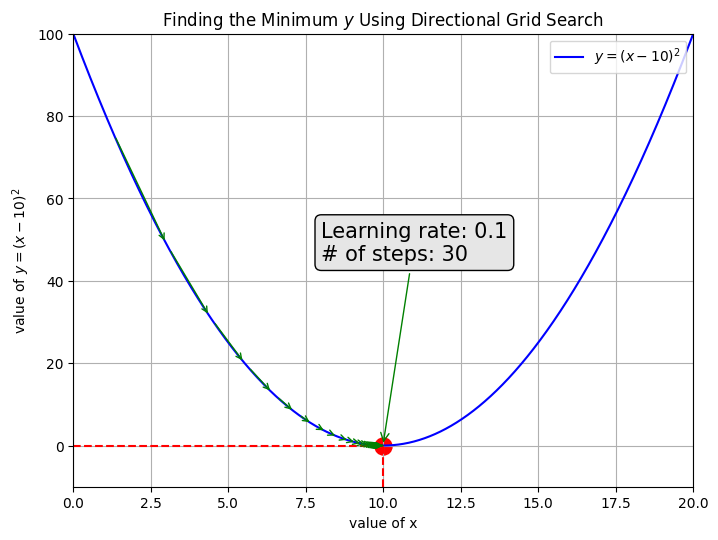

In [3]:
fig, ax=plt.subplots(figsize=(8,6), dpi=100)
plt.grid()
x=np.linspace(0,20,2000)
y=(x-10)**2
ax.plot(x,y,color = 'blue',label="$y=(x-10)^2$")
plt.scatter(best_x, min_y, color = 'red', s=150)
ax.plot([0,10],[0,0],color='red',linestyle='dashed')
ax.plot([10,10],[-10,0],color='red',linestyle='dashed')
ax.set_xlim(0,20)
ax.set_ylim(-10,100)
ax.set_xlabel("value of x")
ax.set_ylabel("value of $y=(x-10)^2$")
ax.set_title("Finding the Minimum $y$ Using Gradient Descent")
plt.legend(loc="upper right")
# add text to explain 
txt = ax.annotate(
    f'''Learning rate: {learning_rate}\n# of steps: {argmin_y}''', 
    xy = (best_x, min_y), 
    xytext = (0.4,0.5), 
    textcoords = 'axes fraction', 
    bbox = dict(boxstyle="round", fc="0.9"), 
    arrowprops=dict(arrowstyle = '->', color = 'g', linewidth = 1), 
    fontsize = 15)
# Show the path of the directional grid search

for k in range(len(xs)-1):
    ax.annotate("", 
    xy = (xs[k+1], ys[k+1]), 
    xytext = (xs[k], ys[k]), 
    textcoords = 'data', 
    bbox = dict(boxstyle="round", fc="0.9"), 
    arrowprops=dict(arrowstyle = '->', color = 'g', linewidth = 1))

## 3. Use Tensorflow to Calculate Gradients

While it's easy to calculate the gradient in the above example when $y=(x-10)^2$, it's extremely complicated to calculate gradients in most machine learning models such as deep neural networks. Luckily, you can use the ***tensorflow*** library for that purpose. 

In this section, you'll first install the ***tensorflow*** library. You'll then learn how to calculate gradients using the library. Finally, you'll solve the optimization problem of finding the lowest $y$ value when $y=(x-10)^2$. You'll use this skill often later in this book because you are required to calculate gradients in many machine learning models (deep neural networks, deep Q learning, policy gradients and so on). 

### 3.1. Install Tensorflow
To install the ***tensorflow*** Python library, run the following line of command in the Anaconda prompt (Windows) or a terminal (Mac or Linux), with your virtual environment ***animatedML*** activated:

`pip install tensorflow` 

Make sure you restart the Jupyter Notebook app on your computer after installation for the library to take effect. 

Or as a shortcut, you can pip install Python libraries in a cell directly. Make sure you put the exclamation mark (!) in front of the command, as follows:

In [25]:
!pip install tensorflow

### 3.2. Calculate Gradients Using Tensorflow
The *gradient()* method can be used to calculate the gradient of a function at any point. The cell below calculates the gradient of $y=(x-10)^2$ when $x=2$.

In [19]:
import tensorflow as tf
from IPython.display import Markdown as md

tfx = tf.Variable(2, dtype='float32') 
with tf.GradientTape() as tape:
    ty=(tfx-10)**2
dydx = tape.gradient(ty,tfx).numpy()        
md(f"the gradient of the function $y=(x-10)^2$ at $x=2$ is {dydx}")   

the gradient of the function $y=(x-10)^2$ at $x=2$ is -16.0

The result above shows that the gradient of the function $y=(x-10)^2$ at $x=2$ is -16, which is the correct answer since $$\frac{dy}{dx}=2(x-10)=2(2-10)=-16.$$

Next, you can calculate the gradient of the function $y=(x-10)^2$ at various point $x=2$, $x=4$,... $x=18$.

In [24]:
import numpy as np

x=np.linspace(0,20,2001)
y=(x-10)**2

for i in range(2001):
    if x[i]%2==0 and 2<=x[i]<=18:
        tfx = tf.Variable(x[i], dtype='float32') 
        with tf.GradientTape() as tape:
            ty=(tfx-10)**2
        dydx = tape.gradient(ty,tfx).numpy()        
        print(f"the gradient at x={x[i]} is {dydx}")  

the gradient at x=2.0 is -16.0
the gradient at x=4.0 is -12.0
the gradient at x=6.0 is -8.0
the gradient at x=8.0 is -4.0
the gradient at x=10.0 is 0.0
the gradient at x=12.0 is 4.0
the gradient at x=14.0 is 8.0
the gradient at x=16.0 is 12.0
the gradient at x=18.0 is 16.0


### 3.3. Use Tensorflow to Conduct Gadient Descent Optimization
We'll revisit the problem of finding the minimum value for $y=(x-10)^2$ at $x=2$. This time, we'll use the ***tensorflow*** library to calculate gradients.

In [26]:
# randomly selects an initial value of x
x0=1.2345
y0=(x0-10)**2

# how much to adjust the value of x each iteration
learning_rate = 0.1

# keep track of the values of x and y
ys = []
xs = []
xs.append(x0)
ys.append(y0)

# starts the gradient descent
x=x0
for i in range(1,2001,1):
    # gradient descent
    tfx = tf.Variable(x, dtype='float32') 
    with tf.GradientTape() as tape:
        ty=(tfx-10)**2
    dydx = tape.gradient(ty,tfx).numpy()      
    x = x - learning_rate * dydx
    # calculate current value of y
    y=(x-10)**2
    # record values of x and y
    xs.append(x)
    ys.append(y)
    # if the incremental change is smaller than 0.0001, stop
    if abs(ys[-1]-ys[-2])<=0.0001:
        print(f"find minimum after {i} steps")
        print(f"the minimum y is {ys[-1]} when x is {xs[-1]}")
        break
    # if y doesn't converge after 2000 iterations, quit
    else:
        if i==2000:
            print("fail to find the minimum")              

# keep track of min_y, argmin_y, and best_x in this case for plots later            
min_y = y
argmin_y = i
best_x = x

find minimum after 30 steps
the minimum y is 0.0001177467707075305 when x is 9.989148881591857


We find exactly the same results as before. Here the only difference is that we have used a different way of calculating gradients. 

### 3.4. Animate the Optimization Process

Next, we'll create an animation of the intermediate steps of the gradient descent optimization algorithm we just used. 

In [4]:

x_points=np.linspace(0,20,2000)
y_points=(x_points-10)**2

for i in range(len(ys)-1):
    xsi, ysi = xs[:i+2], ys[:i+2]
    fig, ax=plt.subplots(figsize=(8,6), dpi=100)
    plt.grid()

    ax.plot(x_points,y_points,color = 'blue',label="$y=(x-10)^2$")
    plt.scatter(xsi[-1], ysi[-1], color = 'red', s=150)
    ax.plot([0,10],[0,0],color='red',linestyle='dashed')
    ax.plot([10,10],[-10,0],color='red',linestyle='dashed')
    ax.set_xlim(0,20)
    ax.set_ylim(-10,100)
    ax.set_xlabel("value of x", fontsize=12)
    ax.set_ylabel("value of $y=(x-10)^2$", fontsize=12)
    ax.set_title("Gradient Descent with A Moderate Learning Rate", fontsize=16)
    plt.legend(loc="upper right", fontsize=15)
    # add text to explain 
    txt = ax.annotate(
        f'''Learning rate: {learning_rate}''', 
        xy = (xsi[-1], ysi[-1]), 
        xytext = (0.64,0.1), fontsize=12,
        textcoords = 'axes fraction', 
        bbox = dict(boxstyle="round", fc="0.9"))

    txt = ax.annotate(
        f'''Step {i+1}\nx = {round(xsi[-1],5)}''', 
        xy = (xsi[-1], ysi[-1]), 
        xytext = (0.4,0.8), 
        textcoords = 'axes fraction', 
        bbox = dict(boxstyle="round", fc="0.9"), 
        arrowprops=dict(arrowstyle = '->', color = 'm', linewidth = 1), 
        fontsize = 15)
        
    # Show the path of gradient descent
    
    for k in range(len(xsi)-1):
        ax.annotate("", 
        xy = (xs[k+1], ys[k+1]), 
        xytext = (xs[k], ys[k]), 
        textcoords = 'data', 
        bbox = dict(boxstyle="round", fc="0.9"), 
        arrowprops=dict(arrowstyle = '->', color = 'g', linewidth = 1))
    
    
    fig.savefig(f"files/ch02/lr_good{i}.png") 
 
    plt.close(fig)


import PIL, imageio
frames=[]
for i in range(len(ys)-1):
    frame=PIL.Image.open(f"files/ch02/lr_good{i}.png") 
    frame=np.asarray(frame)
    frames.append(np.array(frame))
imageio.mimsave('files/ch02/lr_good.gif', frames, fps=5)

find minimum after 30 steps
the minimum y is 0.0001177467707075305 when x is 9.989148881591857


The animation effect can be viewed as follows:

In [3]:
%%HTML
<img src="https://gattonweb.uky.edu/faculty/lium/ml/lr_good.gif" />

## 4. Choose the Right Learning Rate
In the above example, we choose a learning rate of 0.1. That is, in each step, we reduce the parameter by the product of 0.1 and the first derivative of the function at that point. However, how do we know to choose a learning rate of 0.1? In general, it comes from experience. 

Below, I'll show you what happens if the learning rate is too large or too small. 

### 4.1. When the Learning Rate Is Too Large
If the learning rate is too large, we make large changes to the parameters. This leads to wild swings in the parameter values. As a result, the parameter values may not converge. The code in the cell below shows what happens if we choose a learning rate of 0.95. 

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# randomly selects an initial value of x
x0=1.2345
y0=(x0-10)**2

# how much to adjust the value of x each iteration
learning_rate = 0.95

# keep track of the values of x and y
ys = []
xs = []
xs.append(x0)
ys.append(y0)

# starts the gradient descent
x=x0
for i in range(1,2001,1):
    # gradient descent
    tfx = tf.Variable(x, dtype='float32') 
    with tf.GradientTape() as tape:
        ty=(tfx-10)**2
    dydx = tape.gradient(ty,tfx).numpy()      
    x = x - learning_rate * dydx
    # calculate current value of y
    y=(x-10)**2
    # record values of x and y
    xs.append(x)
    ys.append(y)
    # if the incremental change is small than 0.0001, stop
    if abs(ys[-1]-ys[-2])<=0.0001:
        print(f"find minimum after {i} steps")
        print(f"the minimum y is {ys[-1]} when x is {xs[-1]}")
        break
    # if y doesn't converge after 2000 iterations, quit
    else:
        if i==2000:
            print("fail to find the minimum")              

# keep track of min_y, argmin_y, and best_x in this case for plots later            
min_y = y
argmin_y = i
best_x = x

x_points=np.linspace(0,20,2000)
y_points=(x_points-10)**2

for i in range(len(ys)-1):
    xsi, ysi = xs[:i+2], ys[:i+2]
    fig, ax=plt.subplots(figsize=(8,6), dpi=100)
    plt.grid()

    ax.plot(x_points,y_points,color = 'blue',label="$y=(x-10)^2$")
    plt.scatter(xsi[-1], ysi[-1], color = 'red', s=150)
    ax.plot([0,10],[0,0],color='red',linestyle='dashed')
    ax.plot([10,10],[-10,0],color='red',linestyle='dashed')
    ax.set_xlim(0,20)
    ax.set_ylim(-10,100)
    ax.set_xlabel("value of x", fontsize=12)
    ax.set_ylabel("value of $y=(x-10)^2$", fontsize=12)
    ax.set_title("Gradient Descent with A Large Learning Rate", fontsize=16)
    plt.legend(loc="upper right", fontsize=15)
    # add text to explain 
    txt = ax.annotate(
        f'''Learning rate: {learning_rate}''', 
        xy = (xsi[-1], ysi[-1]), 
        xytext = (0.64,0.1), fontsize=12,
        textcoords = 'axes fraction', 
        bbox = dict(boxstyle="round", fc="0.9"))

    txt = ax.annotate(
        f'''Step {i+1}\nx = {round(xsi[-1],5)}''', 
        xy = (xsi[-1], ysi[-1]), 
        xytext = (0.4,0.8), 
        textcoords = 'axes fraction', 
        bbox = dict(boxstyle="round", fc="0.9"), 
        arrowprops=dict(arrowstyle = '->', color = 'm', linewidth = 1), 
        fontsize = 15)
        
    # Show the path of the directional grid search
    
    for k in range(len(xsi)-1):
        ax.annotate("", 
        xy = (xs[k+1], ys[k+1]), 
        xytext = (xs[k], ys[k]), 
        textcoords = 'data', 
        bbox = dict(boxstyle="round", fc="0.9"), 
        arrowprops=dict(arrowstyle = '->', color = 'g', linewidth = 1))
      
    fig.savefig(f"files/ch02/lr_large{i}.png") 
    plt.close(fig)

import PIL, imageio
frames=[]
for i in range(len(ys)-1):
    frame=PIL.Image.open(f"files/ch02/lr_large{i}.png") 
    frame=np.asarray(frame)
    frames.append(np.array(frame))
imageio.mimsave('files/ch02/lr_large.gif', frames, fps=6)

find minimum after 58 steps
the minimum y is 0.0003781270223312588 when x is 9.980554511517289


At a learning rate of 0.95, it takes 58 steps for the parameter to converge. The animation below shows that the value of $x$ swings back and forth wildly, especially in the early stages of training.

In [4]:
%%HTML
<img src="https://gattonweb.uky.edu/faculty/lium/ml/lr_large.gif" />

### 4.2. When the Learning Rate Is Too Small
In contrast, if the learning rate is too small, we make very small changes to the parameters. As a result, it may take a long time for the parameter values to converge. If we require the training process to stop after a fixed number of iterations, the parameters may not converge at all. The code in the cell below shows what happens if we choose a learning rate of 0.0003. 

In [8]:
# randomly selects an initial value of x
x0=1.2345
y0=(x0-10)**2

# how much to adjust the value of x each iteration
learning_rate = 0.0003

# keep track of the values of x and y
ys = []
xs = []
xs.append(x0)
ys.append(y0)

# starts the gradient descent
x=x0
for i in range(1,2001,1):
    # gradient descent
    tfx = tf.Variable(x, dtype='float32') 
    with tf.GradientTape() as tape:
        ty=(tfx-10)**2
    dydx = tape.gradient(ty,tfx).numpy()      
    x = x - learning_rate * dydx
    # calculate current value of y
    y=(x-10)**2
    # record values of x and y
    xs.append(x)
    ys.append(y)
    # if the incremental change is small than 0.0001, stop
    if abs(ys[-1]-ys[-2])<=0.0001:
        print(f"find minimum after {i} steps")
        print(f"the minimum y is {ys[-1]} when x is {xs[-1]}")
        break
    # if y doesn't converge after 2000 iterations, quit
    else:
        if i==2000:
            print("fail to find the minimum")              

# keep track of min_y, argmin_y, and best_x in this case for plots later            
min_y = y
argmin_y = i
best_x = x

x_points=np.linspace(0,20,2000)
y_points=(x_points-10)**2

for i in range(len(ys)-1):
    if i<10 or i%40==0 or i>len(ys)-5:
        xsi, ysi = xs[:i+2], ys[:i+2]
        fig, ax=plt.subplots(figsize=(8,6), dpi=100)
        plt.grid()
    
        ax.plot(x_points,y_points,color = 'blue',label="$y=(x-10)^2$")
        plt.scatter(xsi[-1], ysi[-1], color = 'red', s=150)
        ax.plot([0,10],[0,0],color='red',linestyle='dashed')
        ax.plot([10,10],[-10,0],color='red',linestyle='dashed')
        ax.set_xlim(0,20)
        ax.set_ylim(-10,100)
        ax.set_xlabel("value of x", fontsize=12)
        ax.set_ylabel("value of $y=(x-10)^2$", fontsize=12)
        ax.set_title("Gradient Descent with A Small Learning Rate", fontsize=16)
        plt.legend(loc="upper right", fontsize=15)
        # add text to explain 
        txt = ax.annotate(
            f'''Learning rate: {learning_rate}''', 
            xy = (xsi[-1], ysi[-1]), 
            xytext = (0.64,0.1), fontsize=12,
            textcoords = 'axes fraction', 
            bbox = dict(boxstyle="round", fc="0.9"))
    
        txt = ax.annotate(
            f'''Step {i+1}\nx = {round(xsi[-1],5)}''', 
            xy = (xsi[-1], ysi[-1]), 
            xytext = (0.4,0.8), 
            textcoords = 'axes fraction', 
            bbox = dict(boxstyle="round", fc="0.9"), 
            arrowprops=dict(arrowstyle = '->', color = 'm', linewidth = 1), 
            fontsize = 15)
            
        # Show the path of the directional grid search
        
        for k in range(len(xsi)-1):
            ax.annotate("", 
            xy = (xs[k+1], ys[k+1]), 
            xytext = (xs[k], ys[k]), 
            textcoords = 'data', 
            bbox = dict(boxstyle="round", fc="0.9"), 
            arrowprops=dict(arrowstyle = '->', color = 'g', linewidth = 1))
        
        
        fig.savefig(f"files/ch02/lr_small{i}.png") 
     
        plt.close(fig)


import PIL, imageio
frames=[]
for i in range(len(ys)-1):
    if i<10 or i%40==0 or i>len(ys)-5:
        frame=PIL.Image.open(f"files/ch02/lr_small{i}.png") 
        frame=np.asarray(frame)
        frames.append(np.array(frame))
imageio.mimsave('files/ch02/lr_small.gif', frames, fps=6)

fail to find the minimum


At a learning rate of 0.0003, the parameter $x$ doesn't converge after 2000 iterations. The animation below shows that the value of $x$ changes slowly. To save time, I didn't save all the intermediate steps as pictures. Instead, I only saved the first and last few pictures, plus every 40 pictures in the middle. The animation below shows the learning process.

In [5]:
%%HTML
<img src="https://gattonweb.uky.edu/faculty/lium/ml/lr_small.gif" />

## 5. Combine Three Animations into One
For comparison purpose, I'll combine the three animations into one. In each frame, I put the three scenarios side by side: one the left is when the learning rate is too large; in the middle, the learning rate is optimal; on the right, the learning rate is too small.  

In [10]:
import imageio
import os
import matplotlib.pyplot as plt
import PIL
import numpy as np


# Gather three types of pictures
smalls, goods, larges = [], [], []

for i in range(2000):
    if i<10 or i%40==0 or i>2001-5:
        frame=PIL.Image.open(f"files/ch02/lr_small{i}.png") 
        frame=np.asarray(frame)
        smalls.append(np.array(frame))

for i in range(30):
    frame=PIL.Image.open(f"files/ch02/lr_good{i}.png") 
    frame=np.asarray(frame)
    goods.append(np.array(frame))

for i in range(58):
    frame=PIL.Image.open(f"files/ch02/lr_large{i}.png") 
    frame=np.asarray(frame)
    larges.append(np.array(frame))

frames=[]
for i in range(30):
    frame=np.concatenate([larges[i], goods[i], smalls[i]],axis=1) 
    frames.append(np.array(frame))
imageio.mimsave('files/ch02/largetosmall.gif', frames, fps=6) 

Now we can see the three scenarios side by side, as in the following animation.

In [6]:
%%HTML
<img src="https://gattonweb.uky.edu/faculty/lium/ml/largetosmall.gif" />